In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

#np.random.seed(123)

## Vamos a hacer un MCMC de manera rápida. Para hacer esta estimación debemos partir del teorema de Bayes

## $P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}$

## Donde 

## $*$ $P(x)=\int_\theta P(x,\theta)d\theta$ es la evidencia

## $*$ $P(\theta)$ es el prior

## $*$ $P(x|\theta)$ es el Likelihood

## $*$ $P(\theta|x)$ Es el posterior

## Generamos números aleatorios con distribución normal y los ploteamos en un histograma

In [3]:
data = np.random.randn(50)

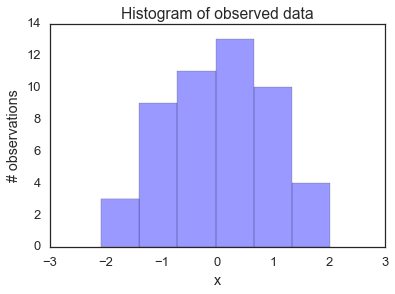

In [4]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');
plt.show()

## Para simplificar las cosas digamos que ya conocemos algunas cosas de nuestros datos. Por ejemplo podemos asumir que los datos son distribuidos normalmente por lo que podemos considerar un Likelihood Gaussiano. 

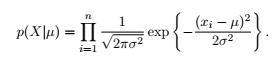

In [134]:
Image("mcmc1.png")


## Asumamos también que nuestro prior para $\mu$ es Gaussiano.

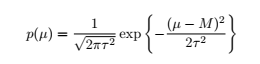

In [135]:
Image("mcmc2.png")

## Cuando tenemos un prior y Likelihood gaussianos es posible calcular de forma analítica el posterior. De hecho este posterior nuevamente posee una distribución Gaussiana con media:

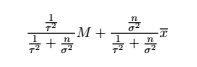

In [136]:
Image("mcmc3.png")

## Y desviación estandar:

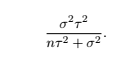

In [137]:
Image("mcmc4.png")

## Digamos que además conocemos que el parámetro de desviación estandar de los datos son $\sigma^2=1$ y estamos interesados en saber cual es el valor de $\mu$. 

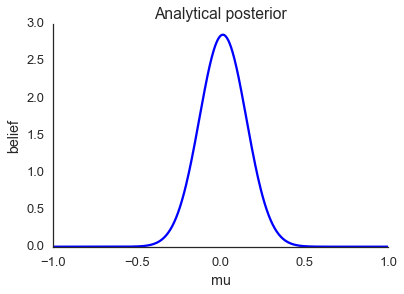

In [138]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()
plt.show()

# COMENCEMOS CON NUESTRO CÓDIGO MCMC

## Iniciamos nuestra cadena con un paso arbitrario. Digamos que arbitrariamente elegimos:

In [139]:
mu_current = 1.

### 1.- Proponemos movernos de nuestra posición a algún otro lado (Esa es la parte Markov). Vamos a generar un nuevo candidato de alguna función, por ejemplo de una distribución Gaussiana centrada al rededor de nuestro valor actual para $\mu$.  La desviación estandar se relaciona con el tamaño de los pasos que daremos.

### 2.- Aceptamos o no nuestro nuevo punto:

### $p(acceptance)=min\left[1,\frac{p_c}{p_0}\right]$
    
###    $p_c$ es el posterior de nuestro nuevo punto y $p_0$ es el posterior del punto actual.

### 3.- Si el punto no es aceptado se repite el anterior

### 4.- Repetimos los pasos 1-3 hasta que haya convergido nuestra cadena a un punto estacionario. Para eso existen criterios de convergencia.

In [140]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # PASO 1
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # SE CALCULAN LOS LIKELIHOODS PARA OBTENER LOS POSTERIORES
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # SE CALCULAN LOS PRIORS PARA OBTENER LOS POSTERIORES
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        ## CALCULAMOS p_c Y p_0
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # NUESTRA PROBABILIDAD DE ACEPTAR
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # SE GRAFICAN LOS PRIOR
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # LIKELIHOOD
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

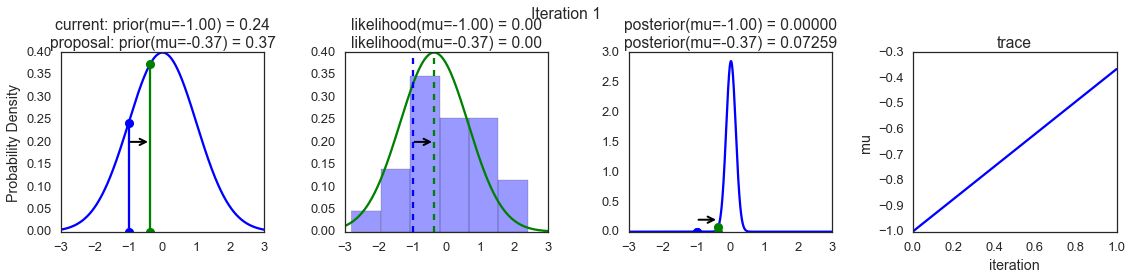

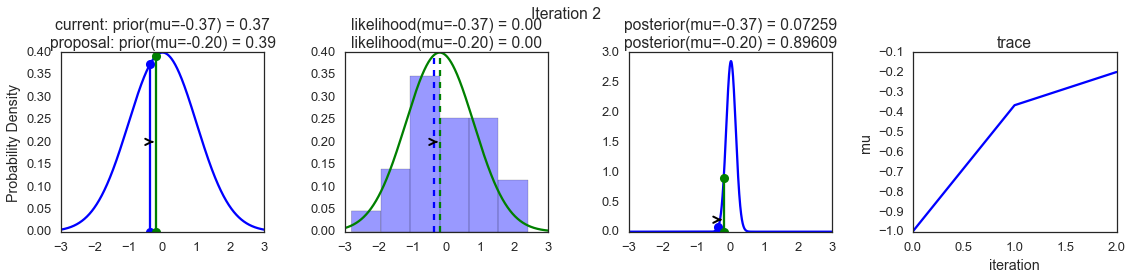

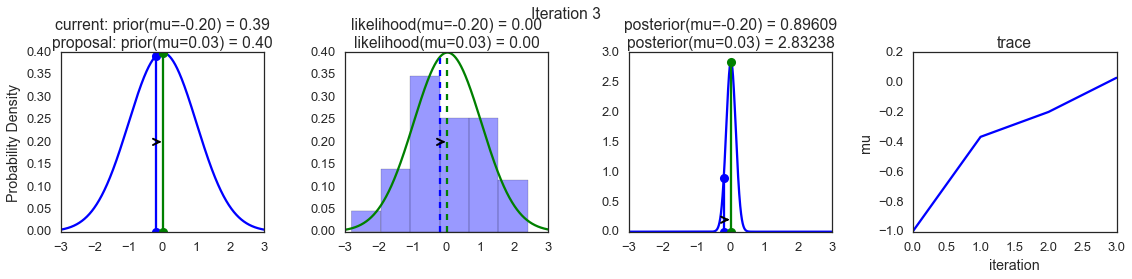

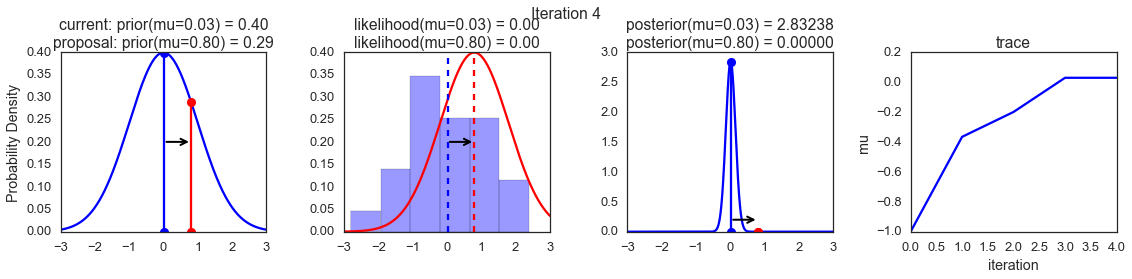

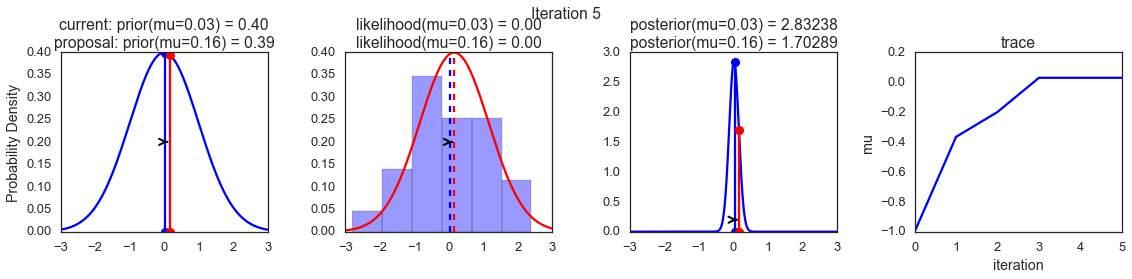

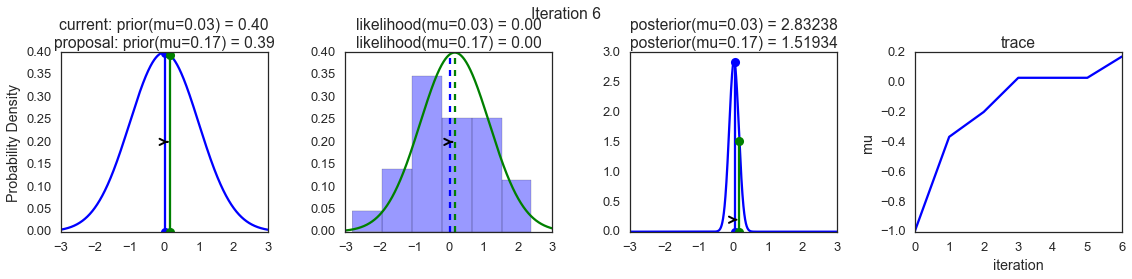

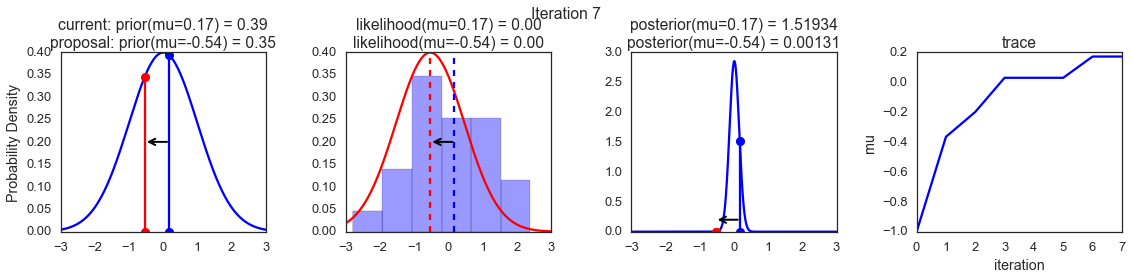

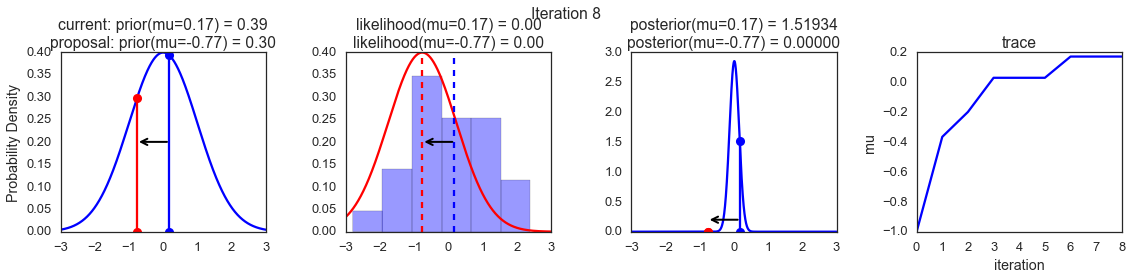

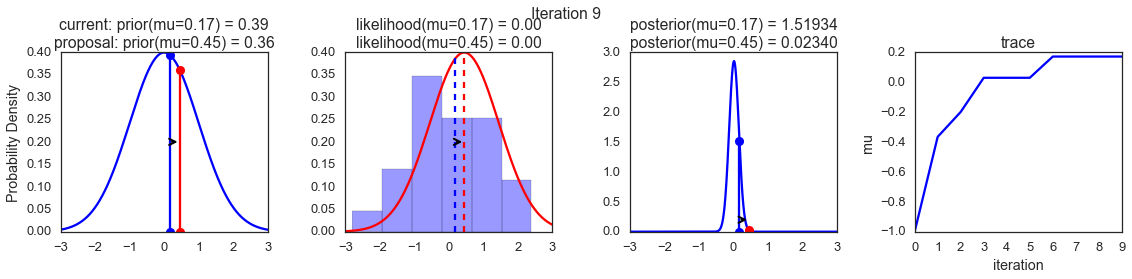

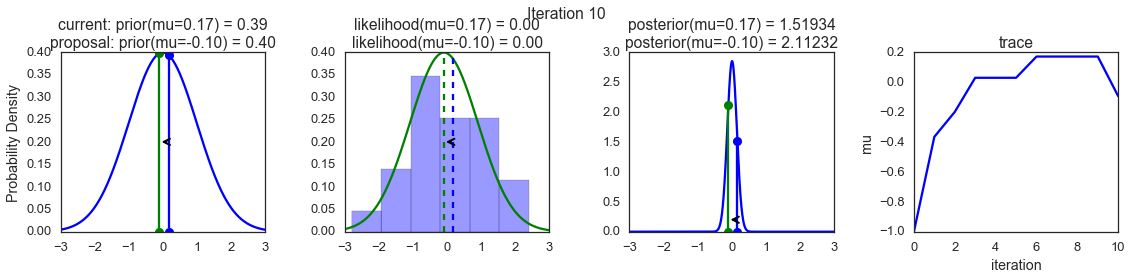

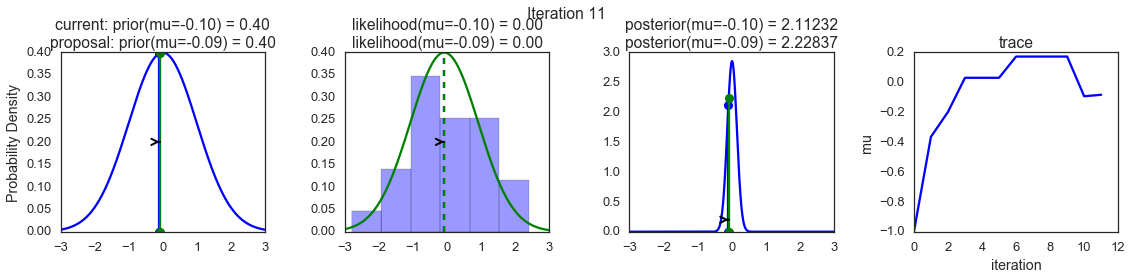

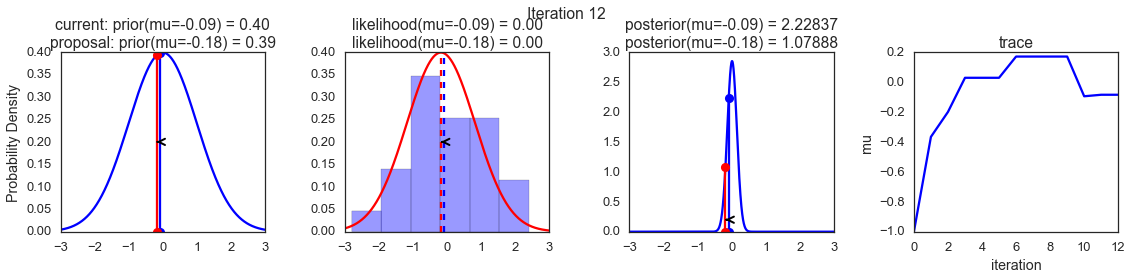

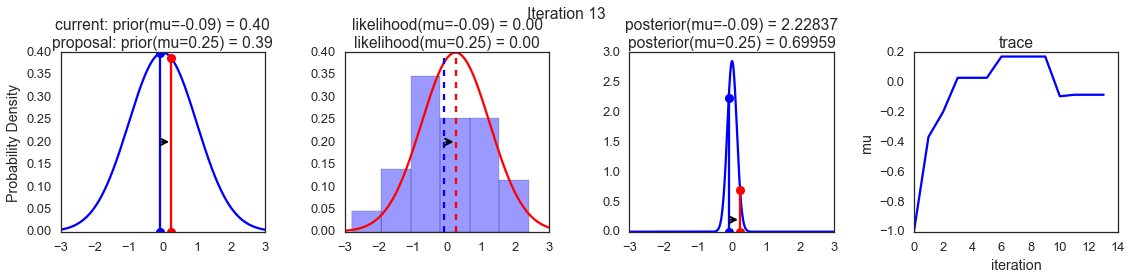

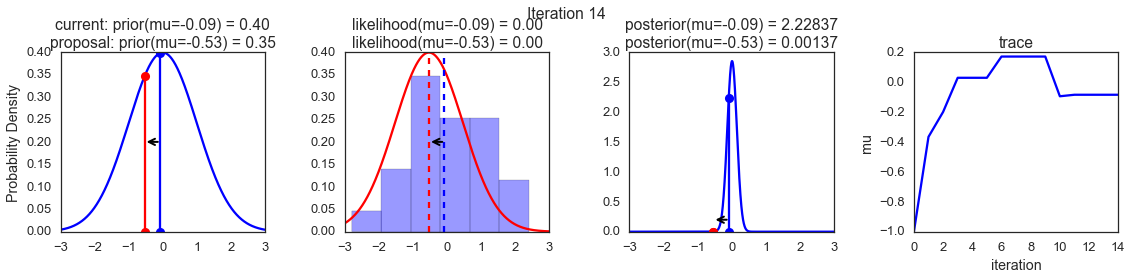

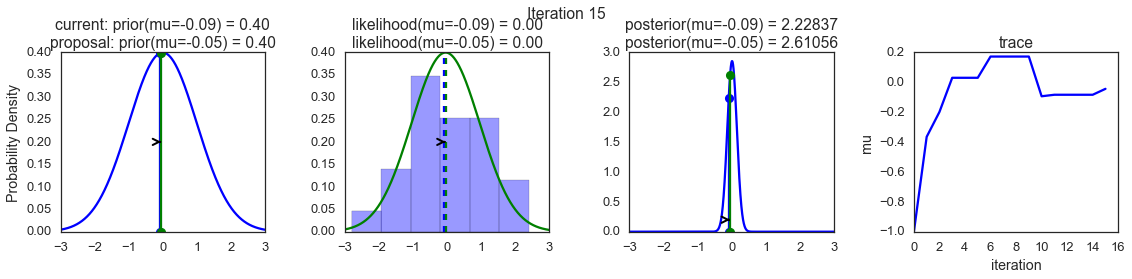

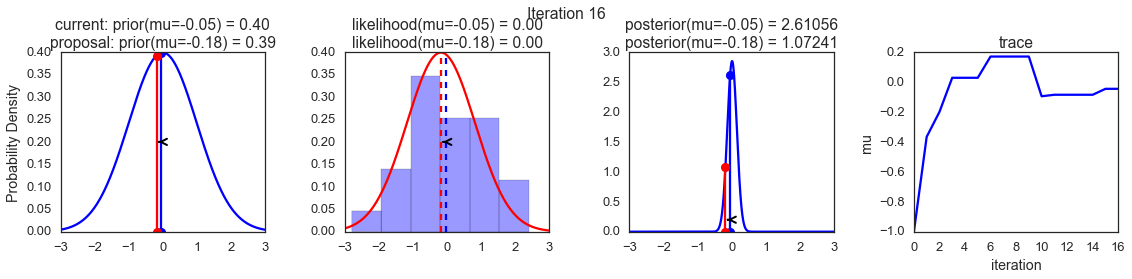

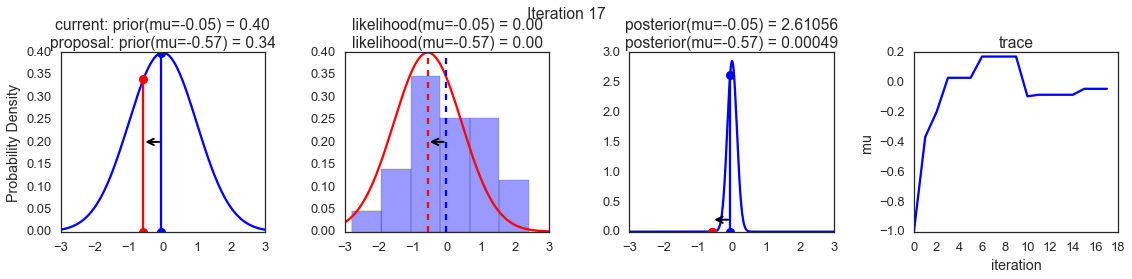

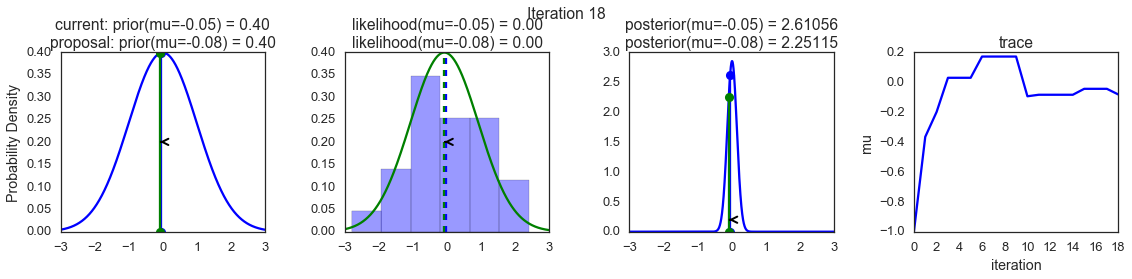

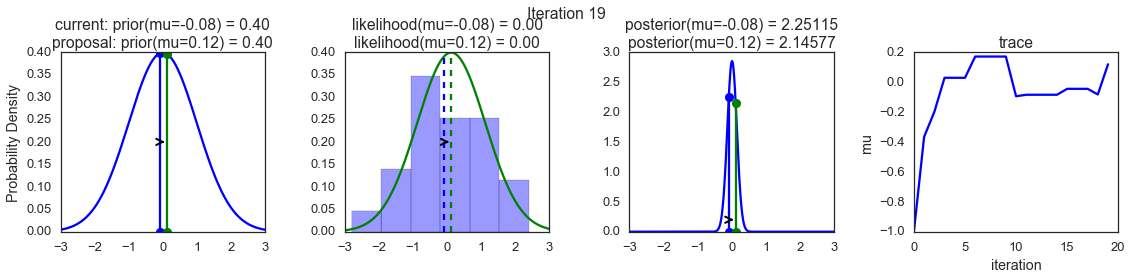

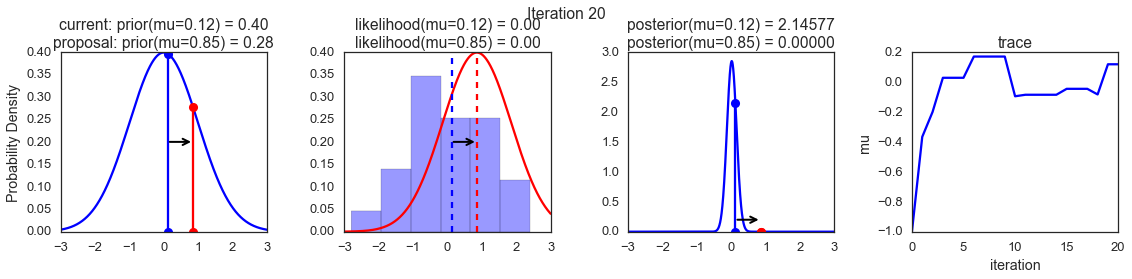

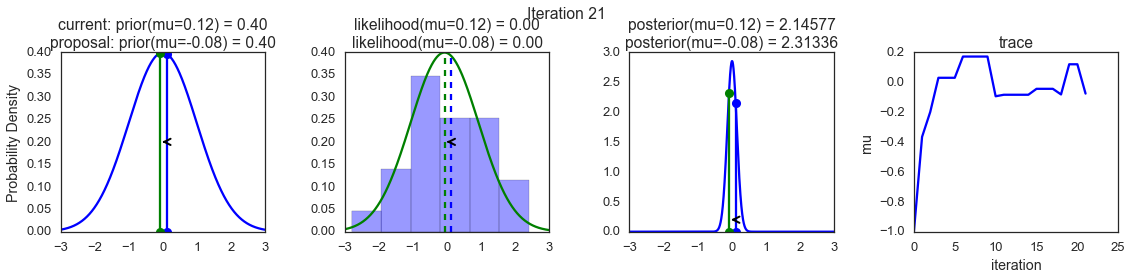

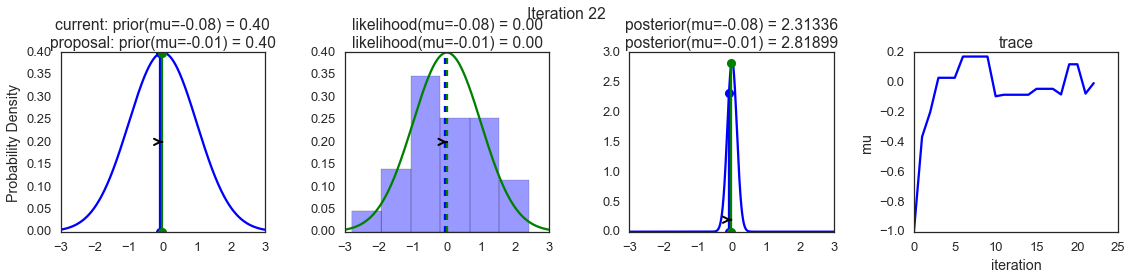

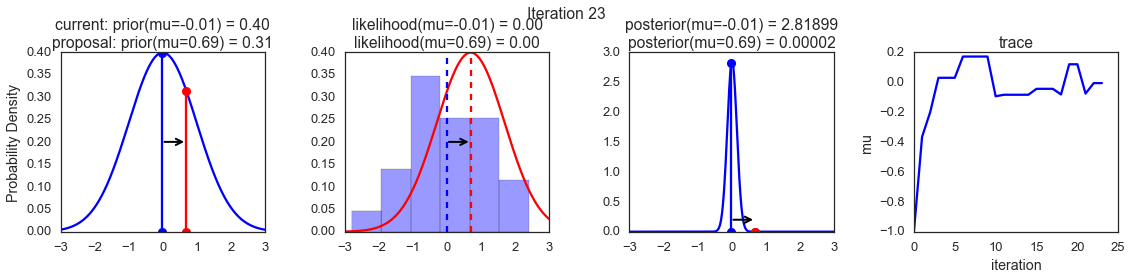

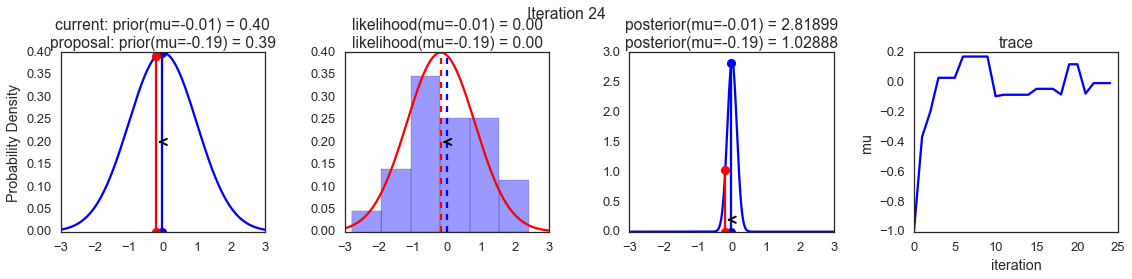

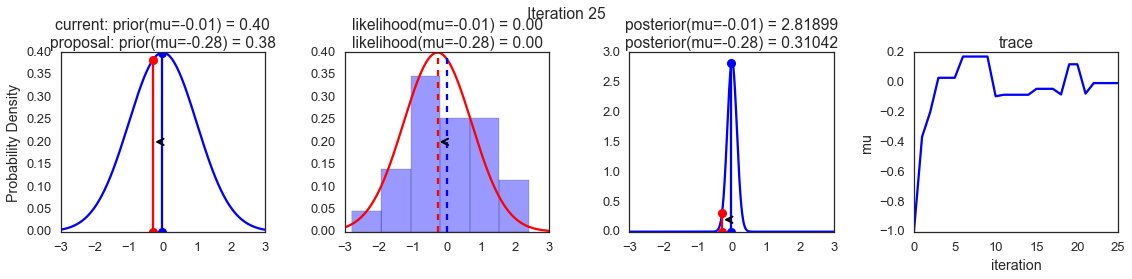

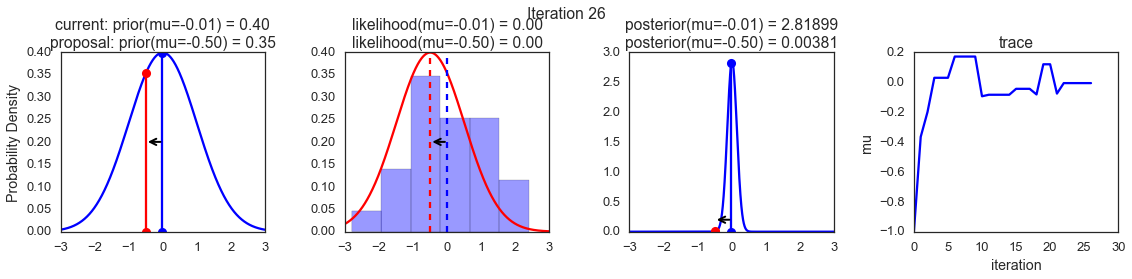

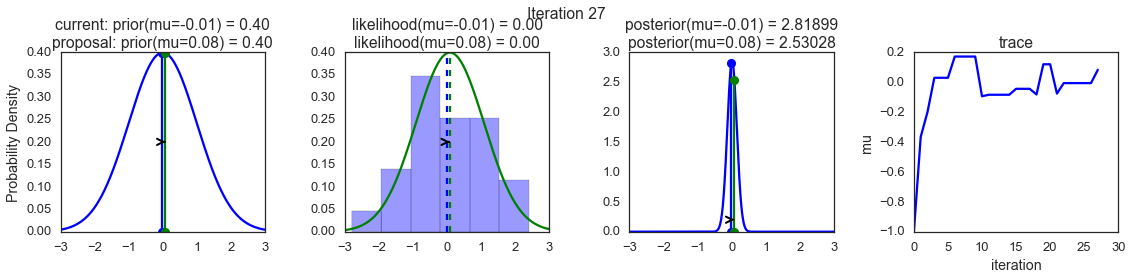

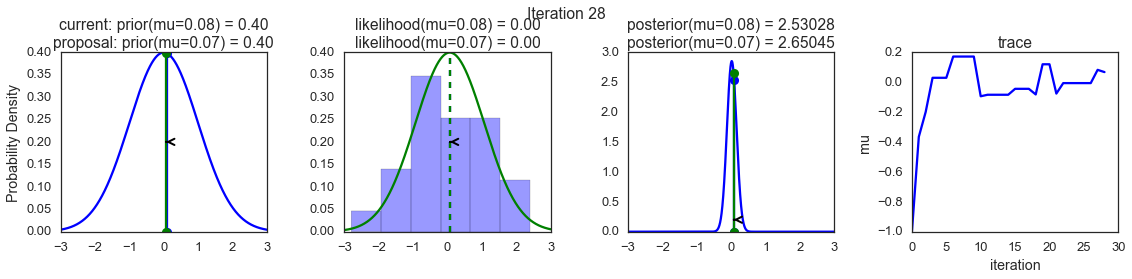

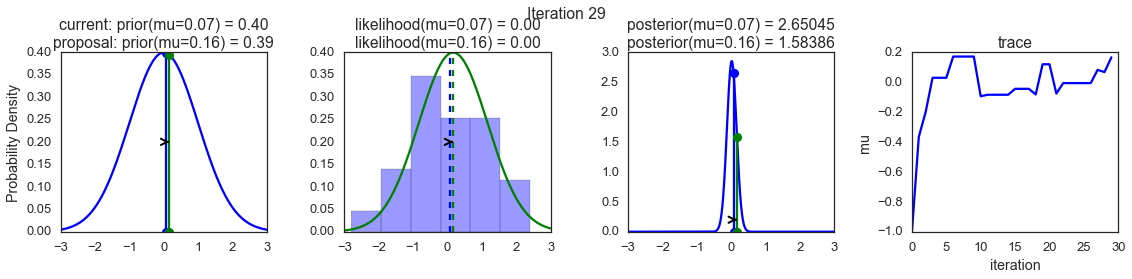

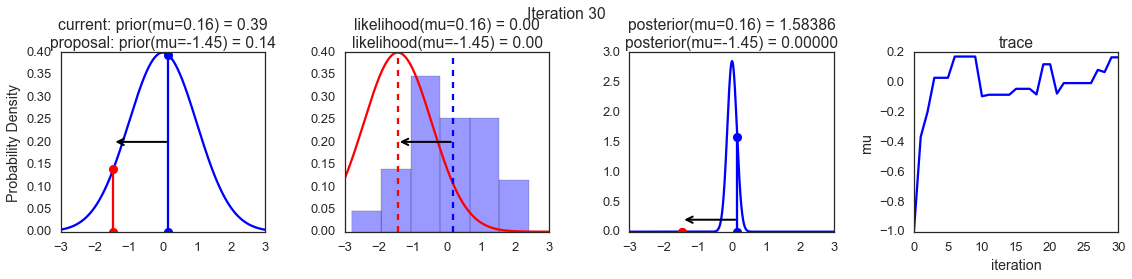

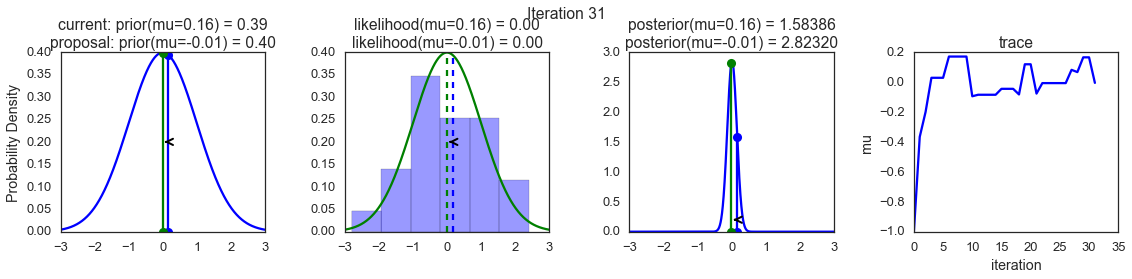

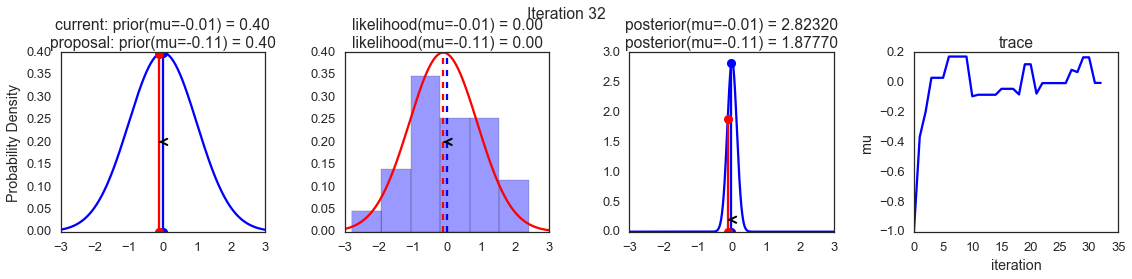

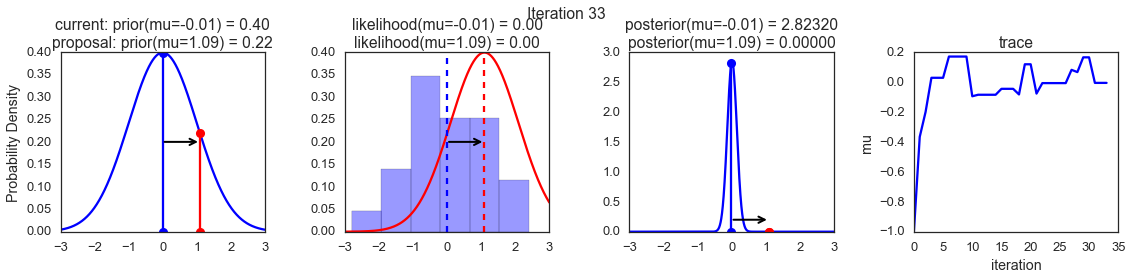

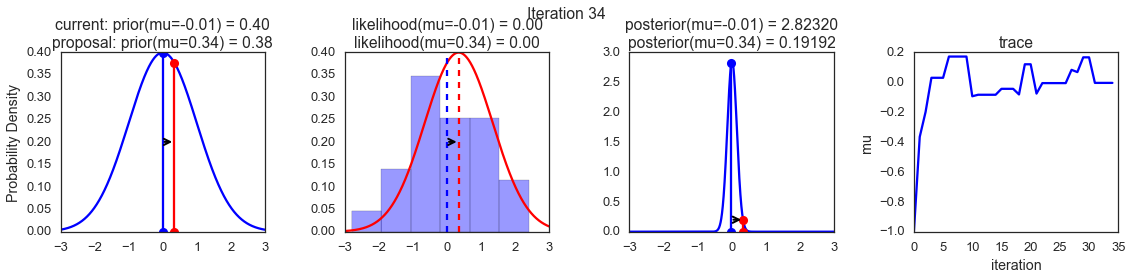

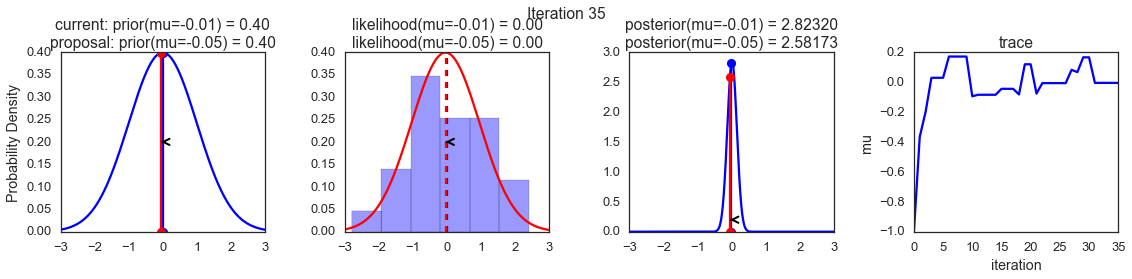

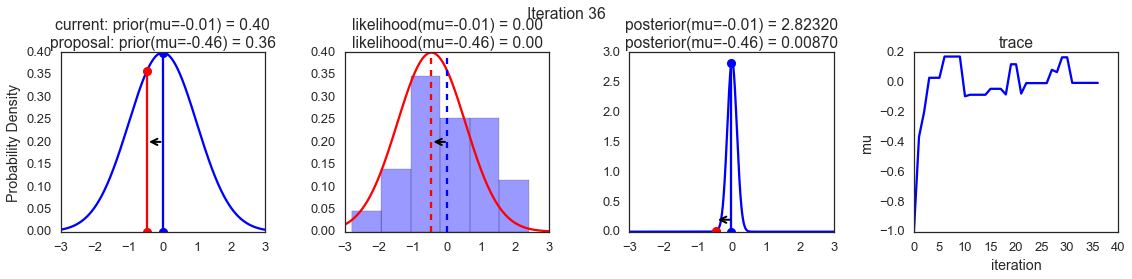

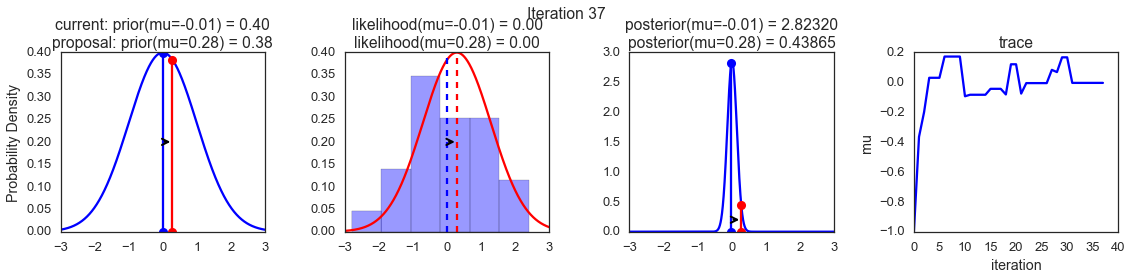

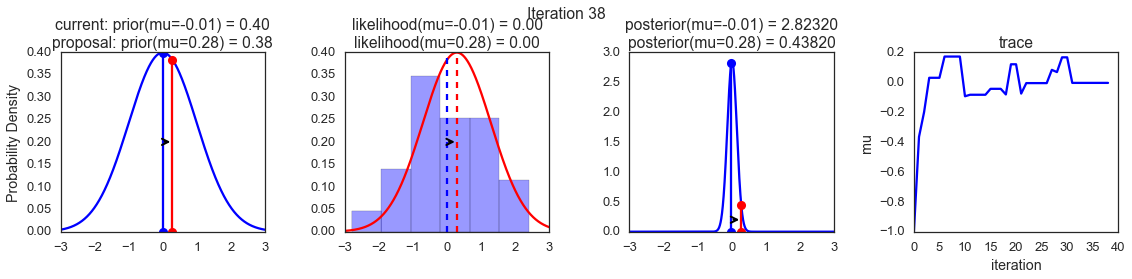

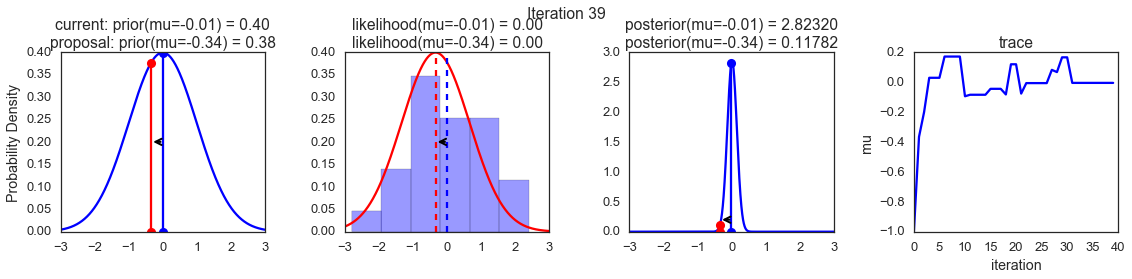

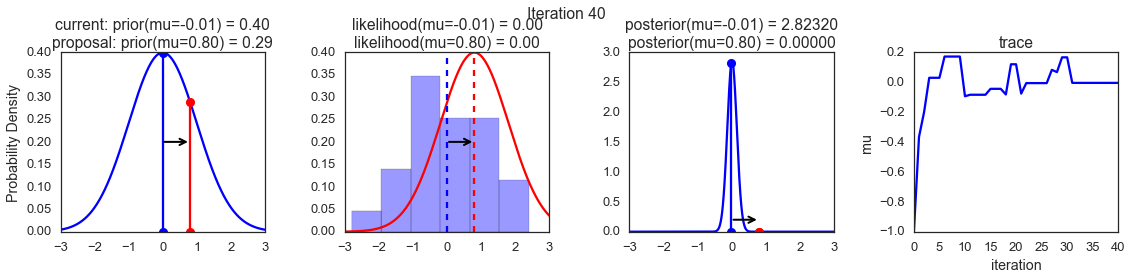

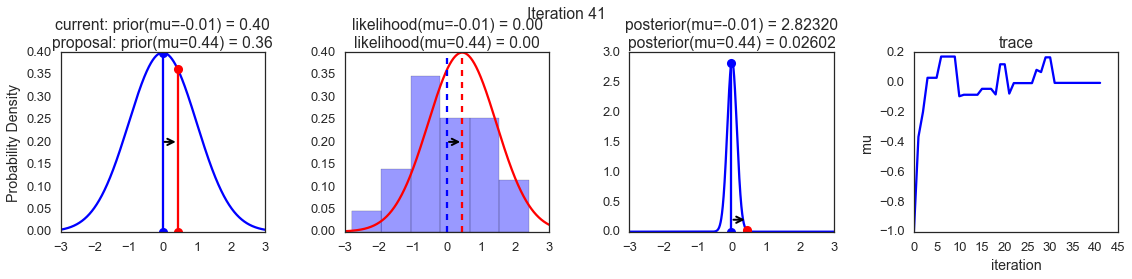

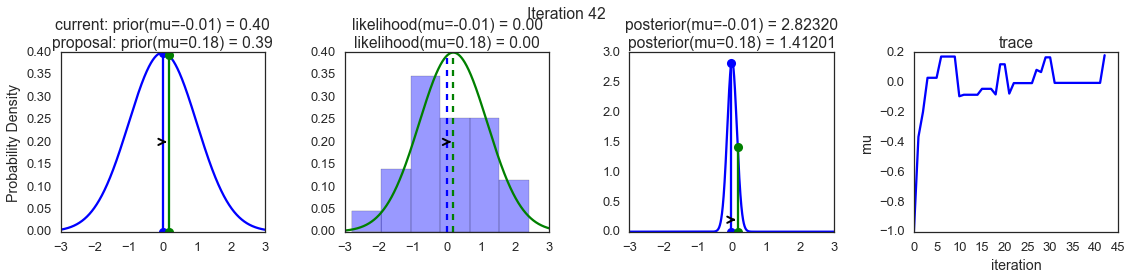

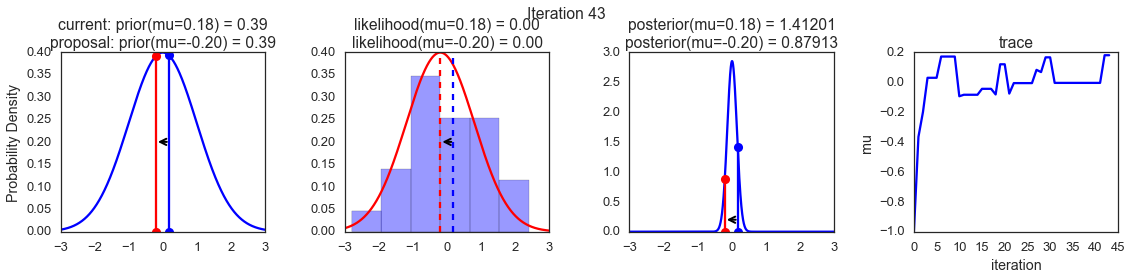

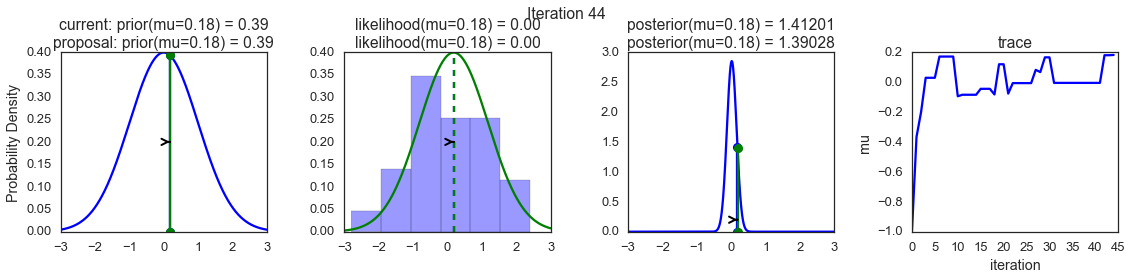

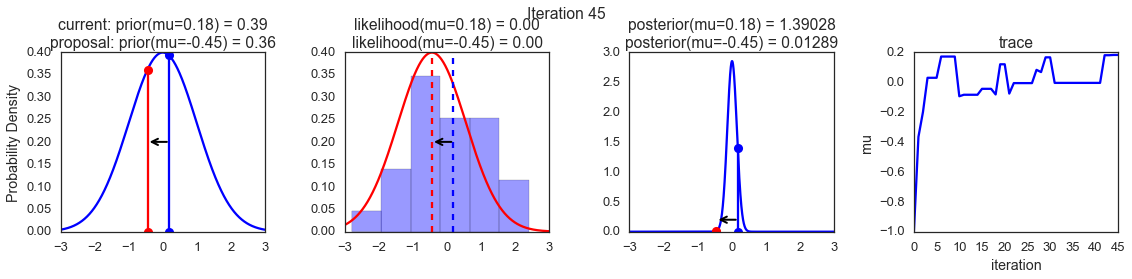

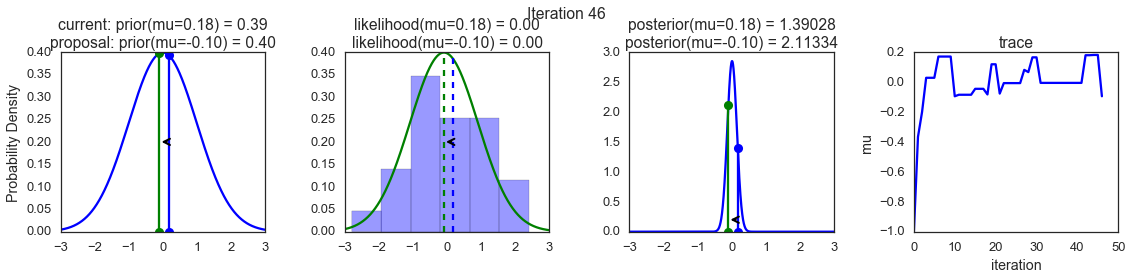

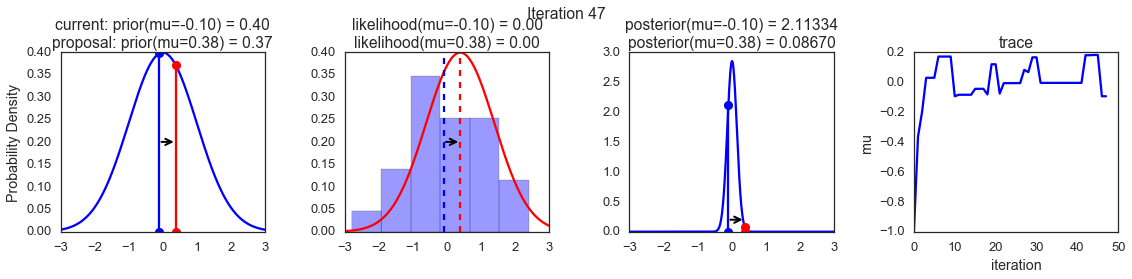

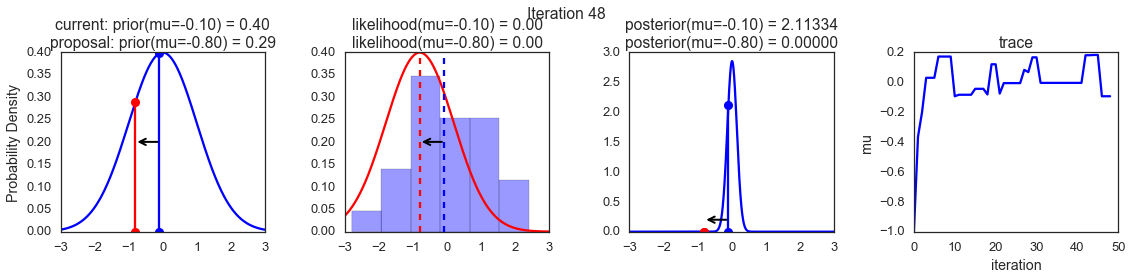

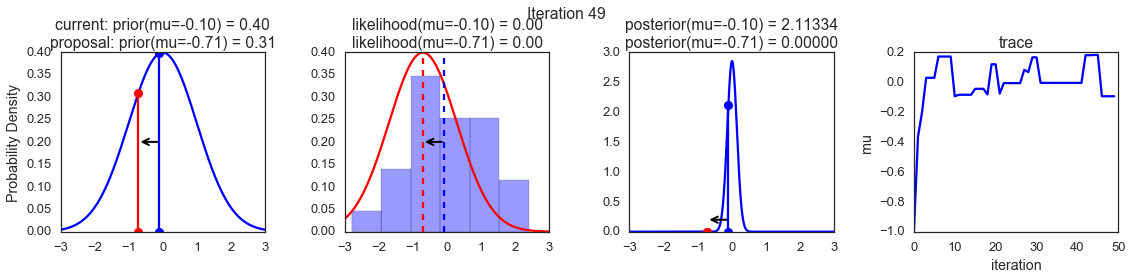

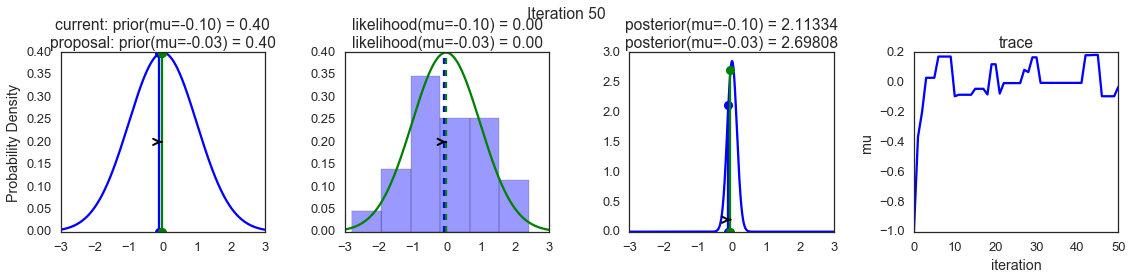

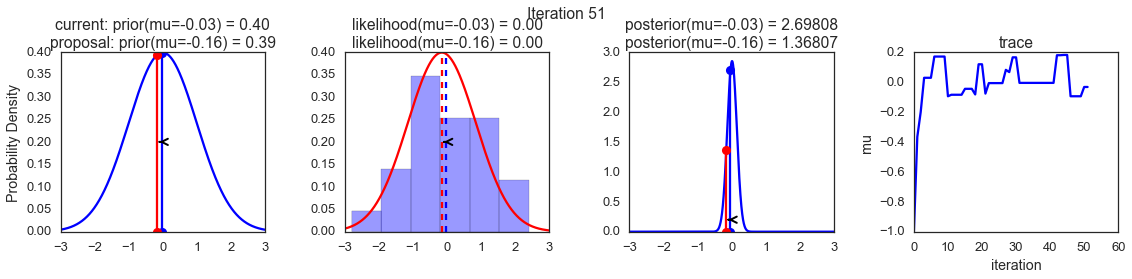

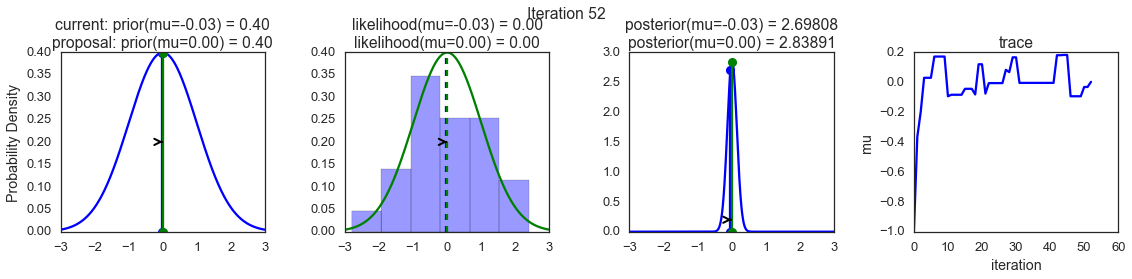

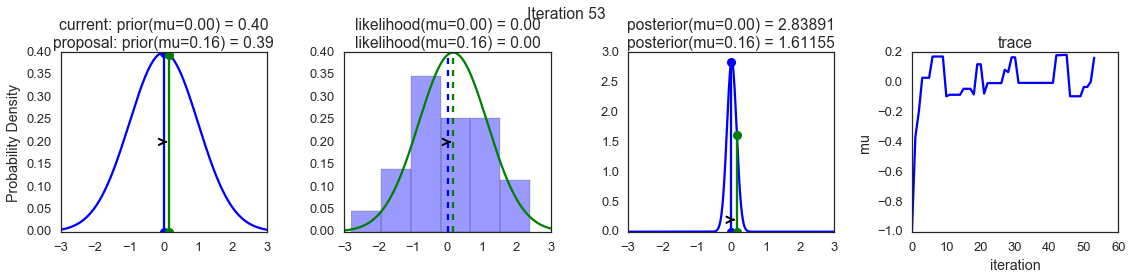

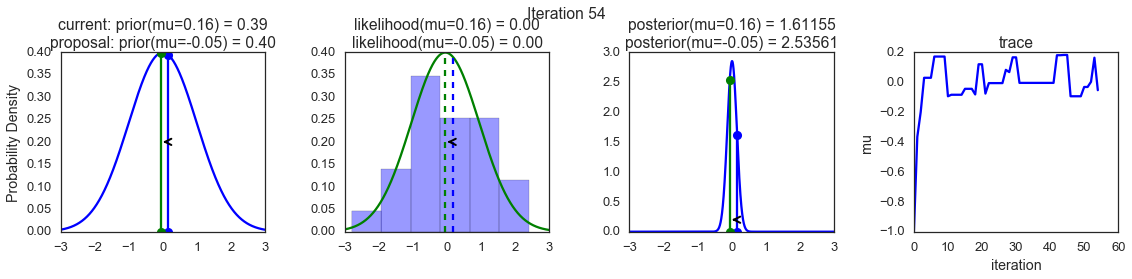

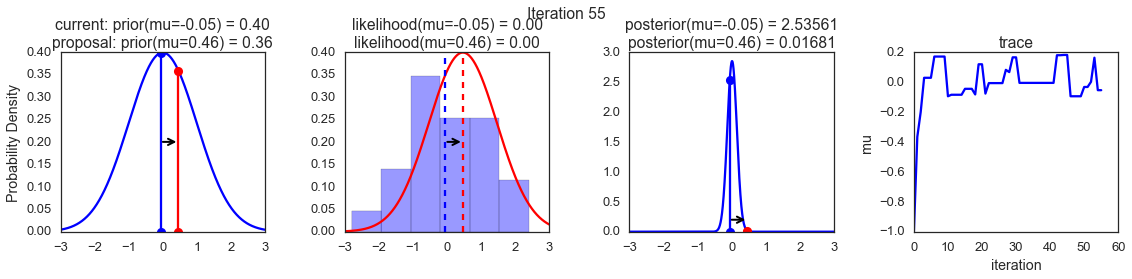

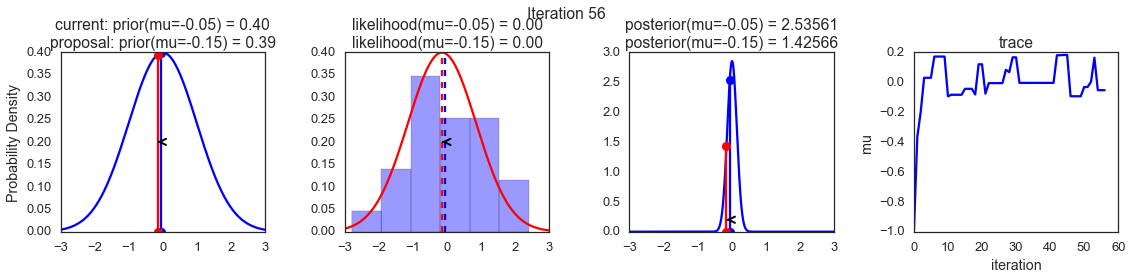

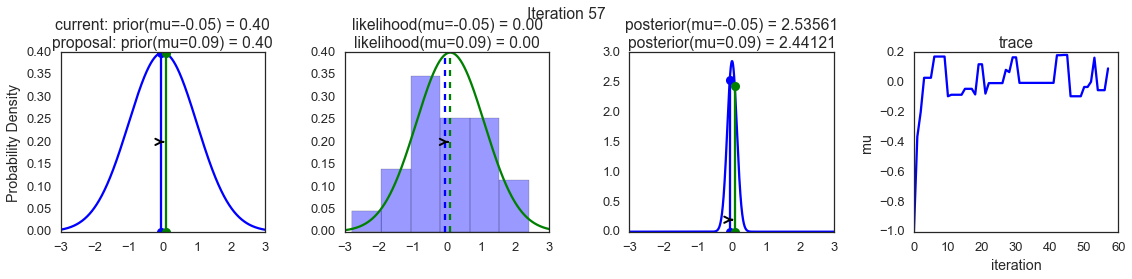

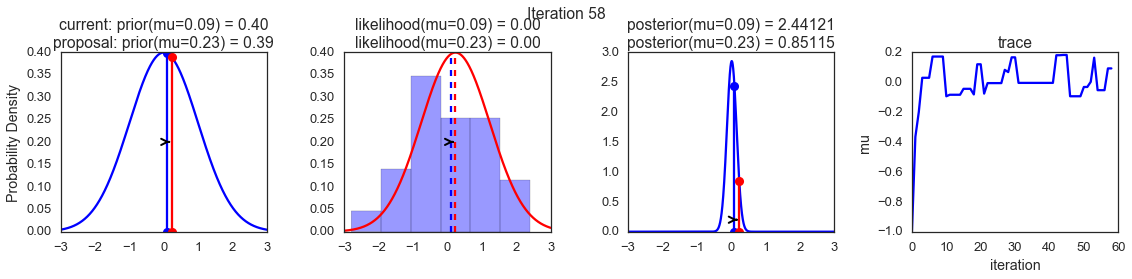

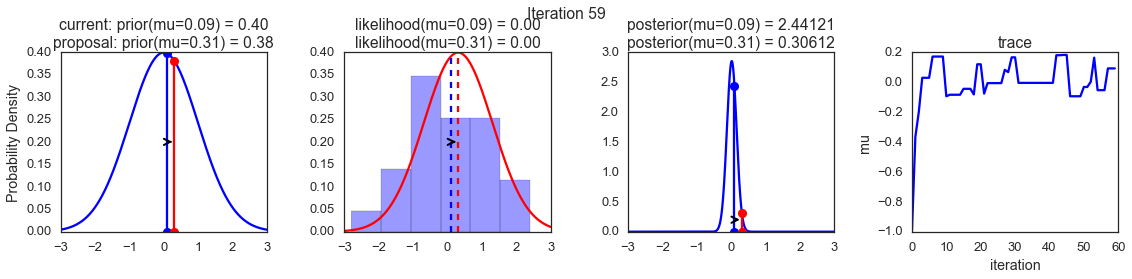

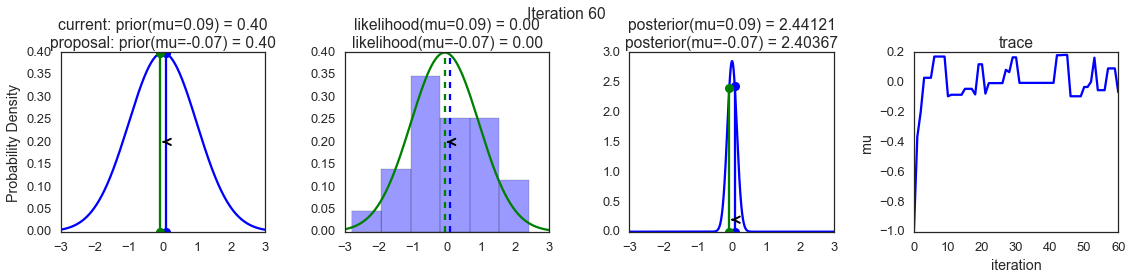

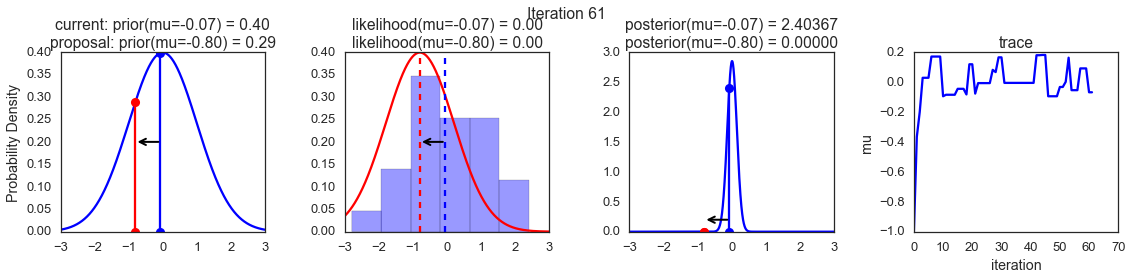

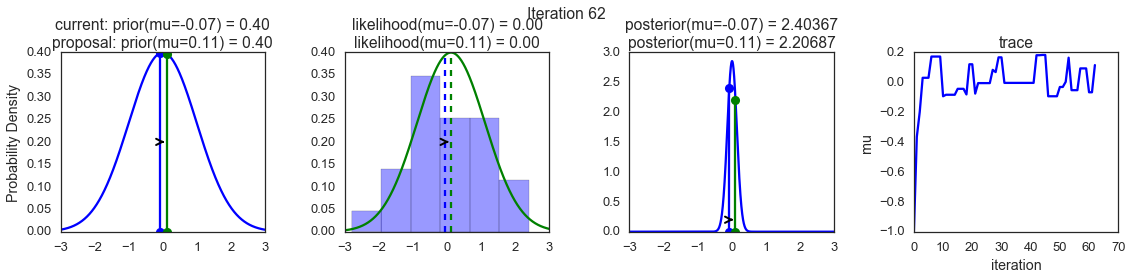

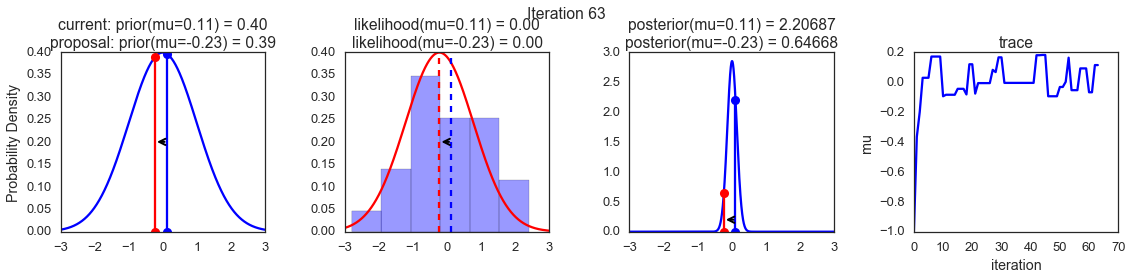

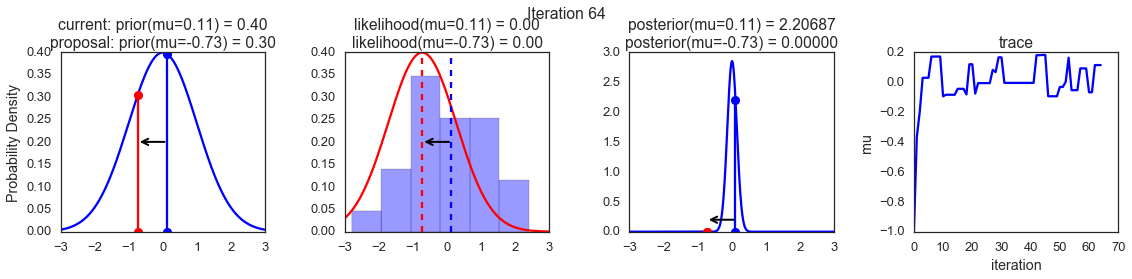

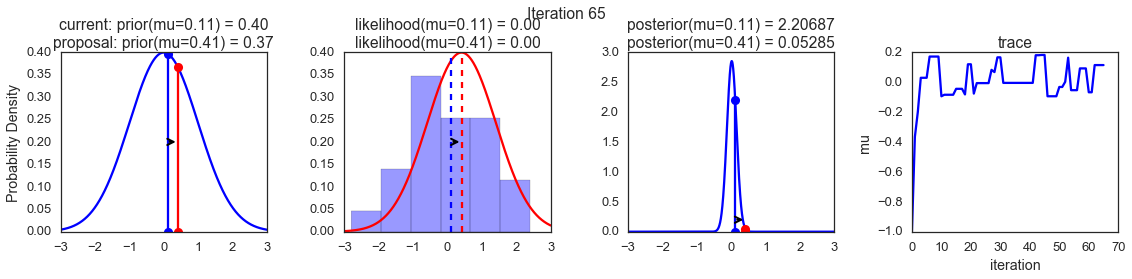

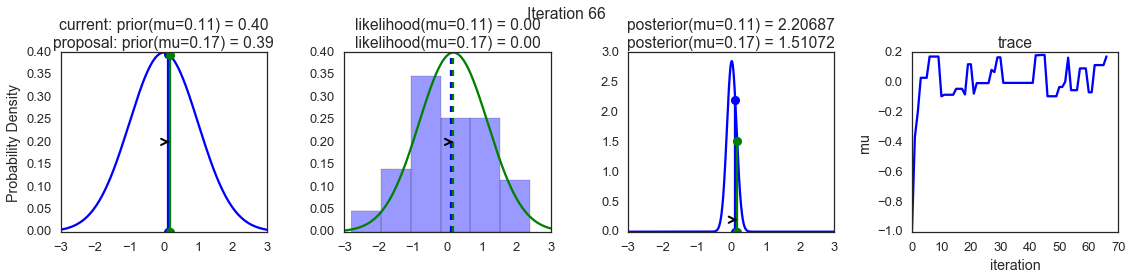

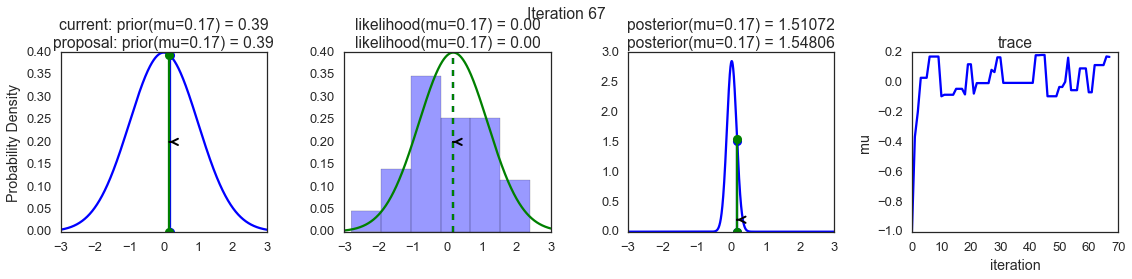

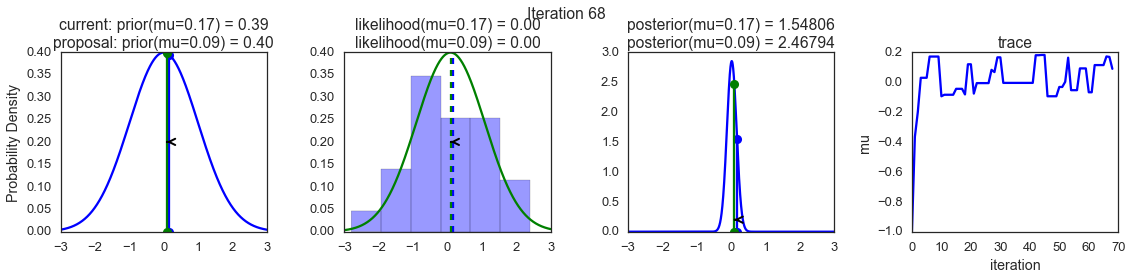

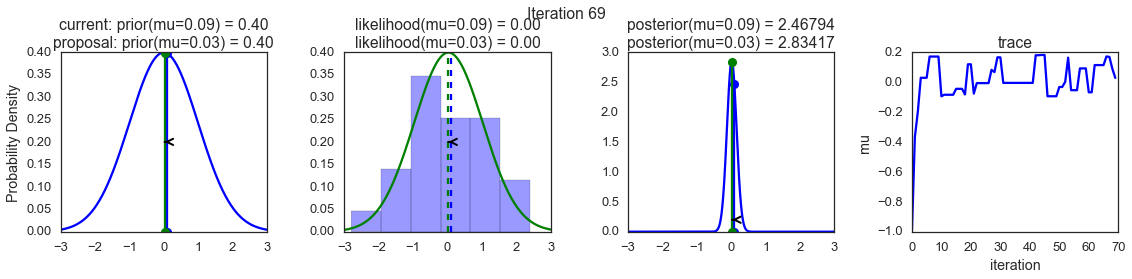

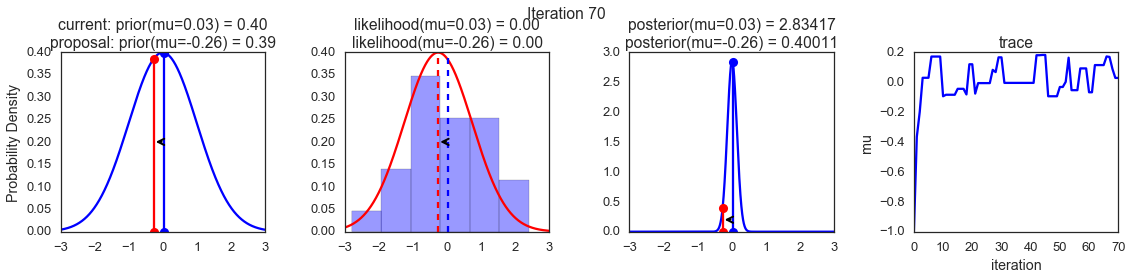

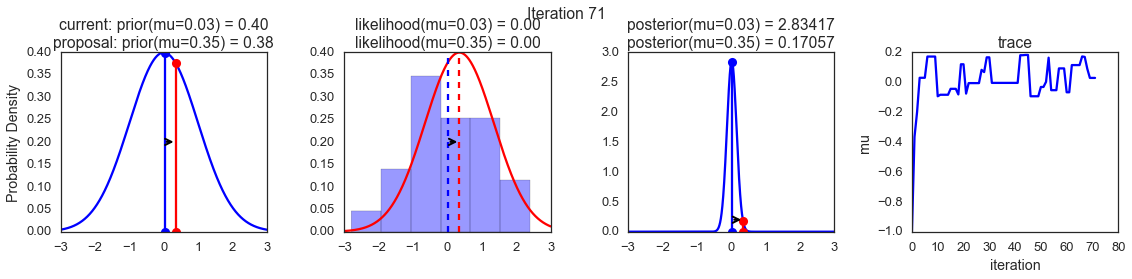

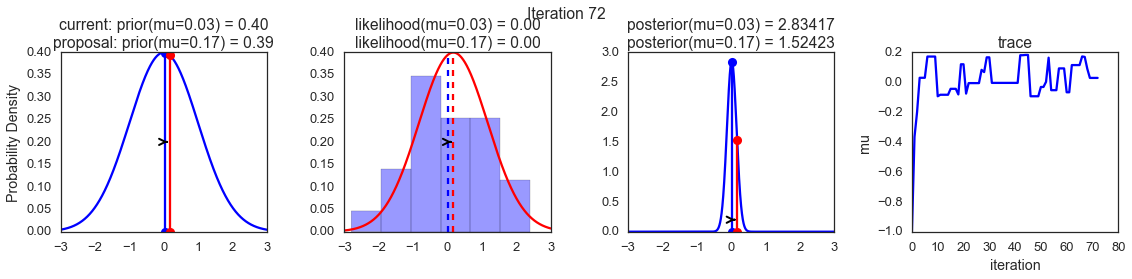

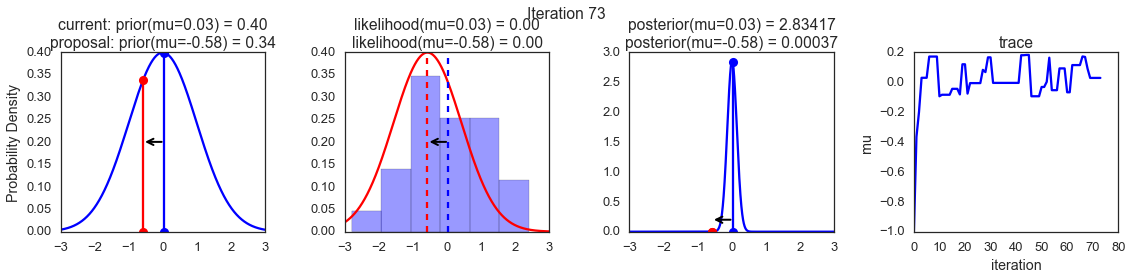

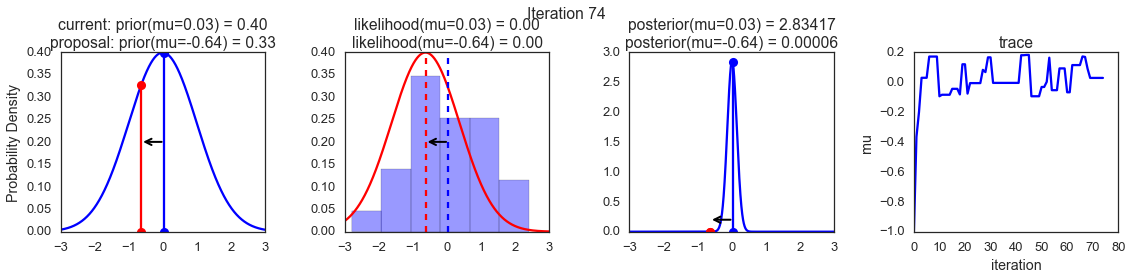

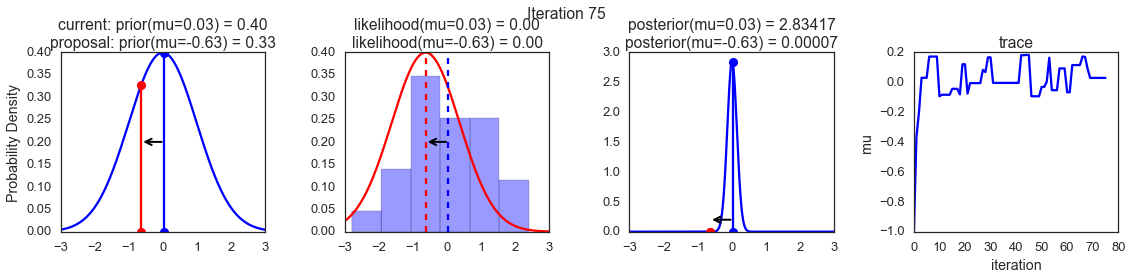

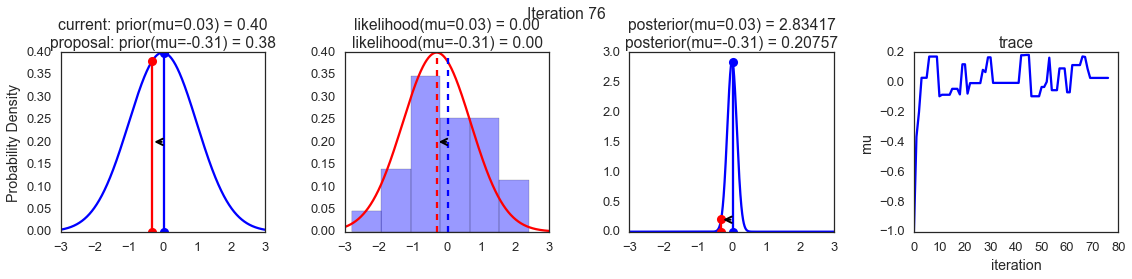

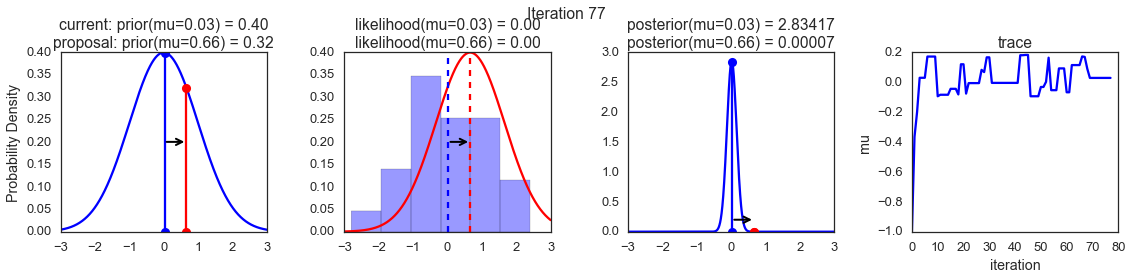

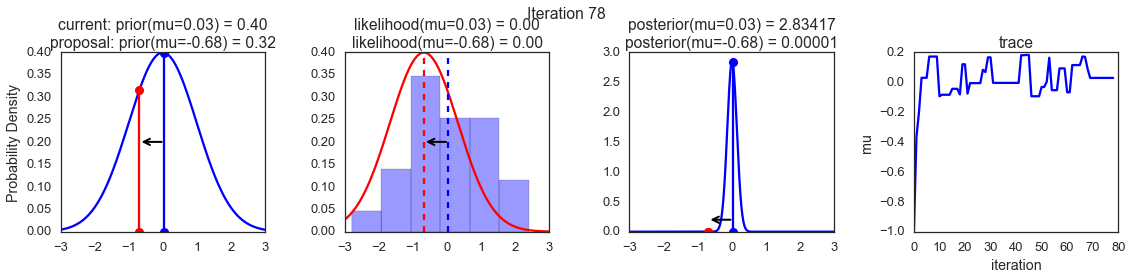

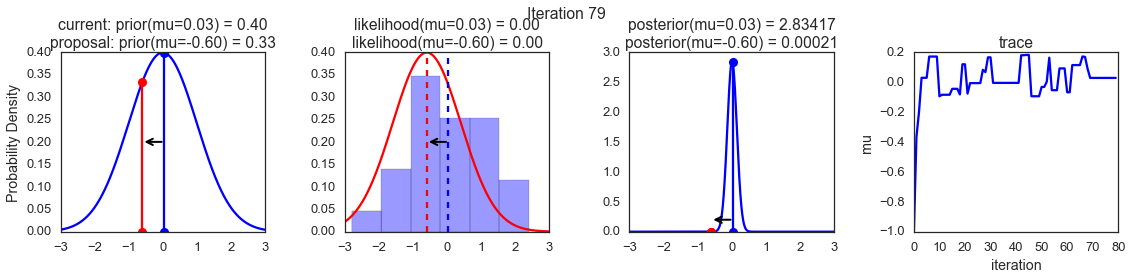

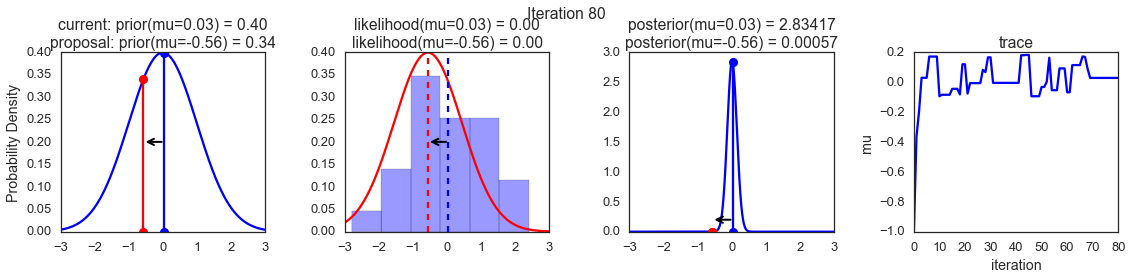

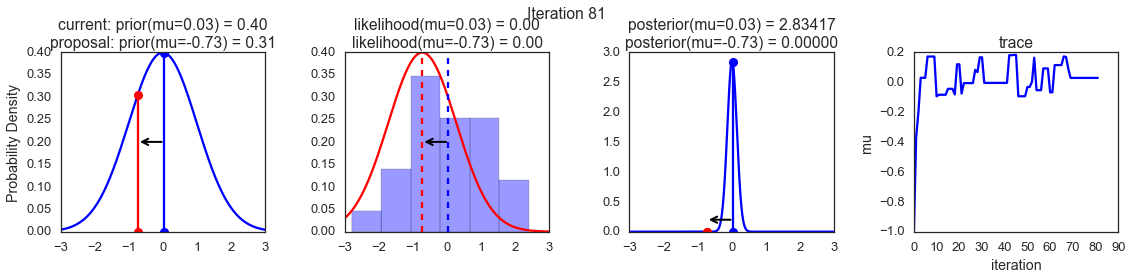

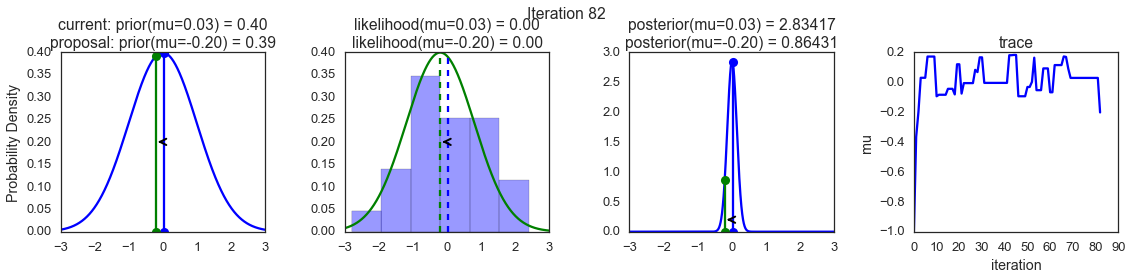

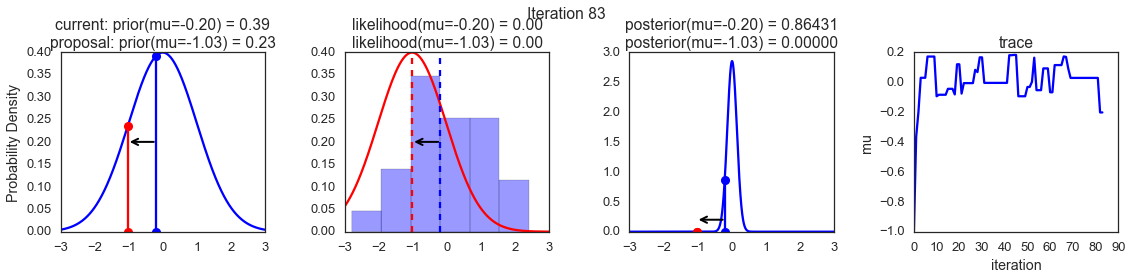

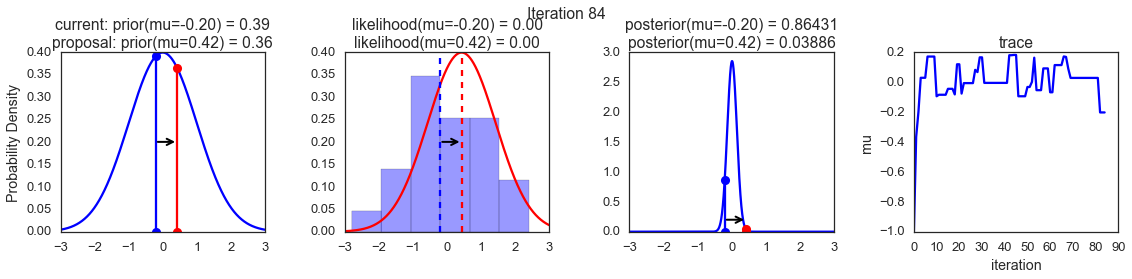

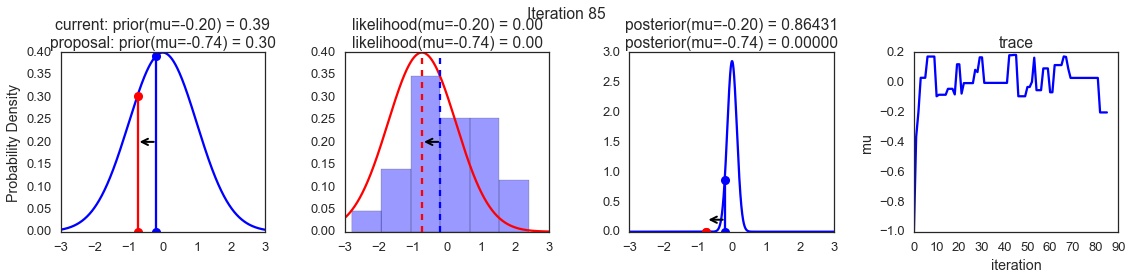

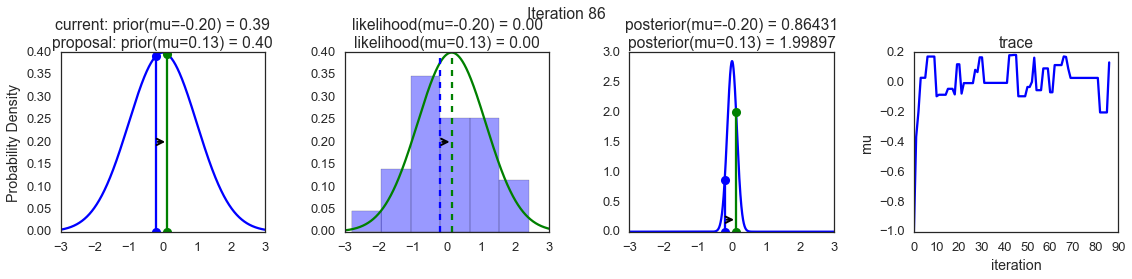

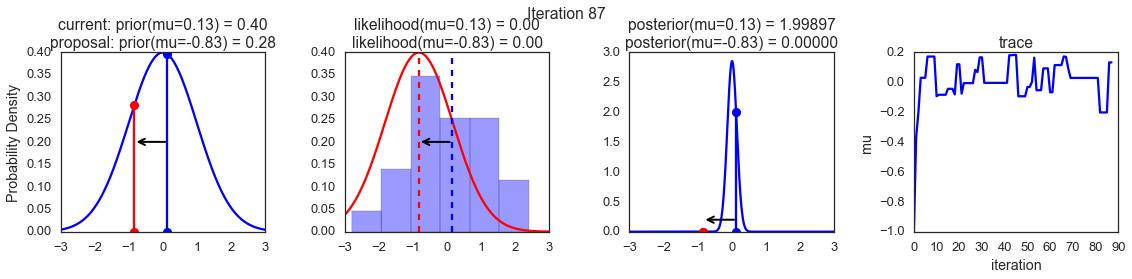

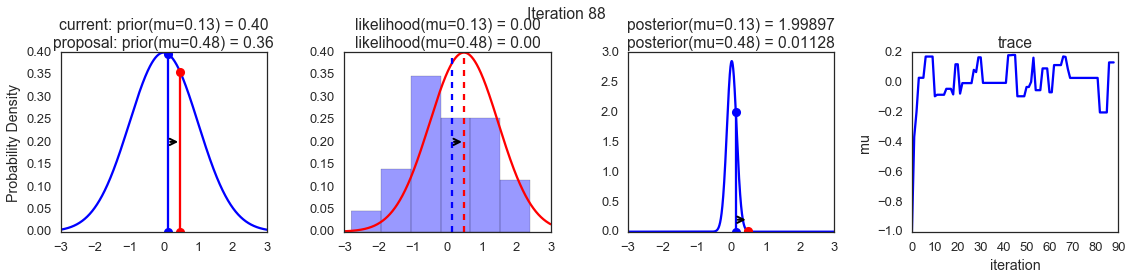

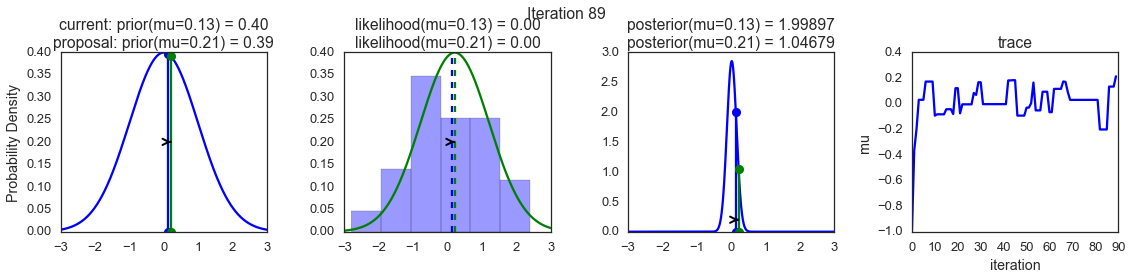

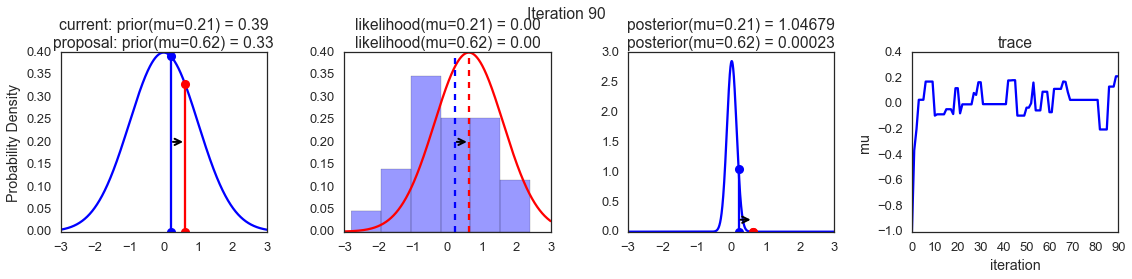

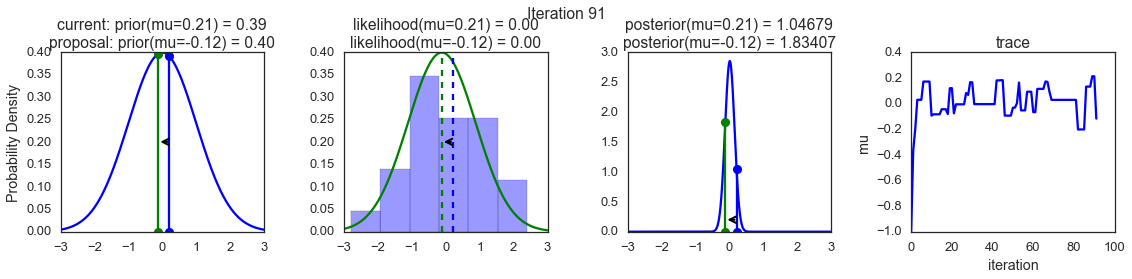

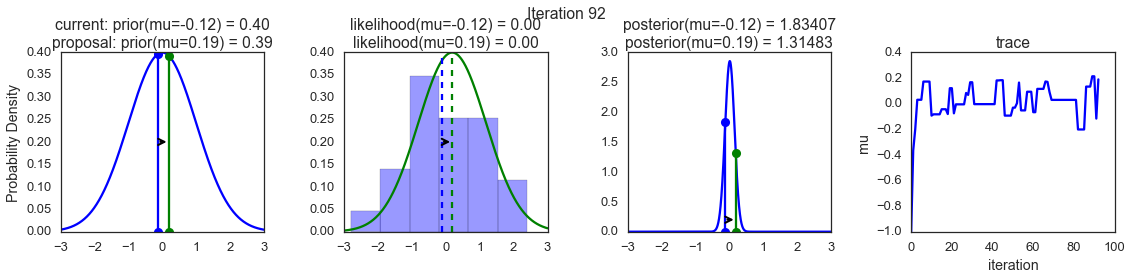

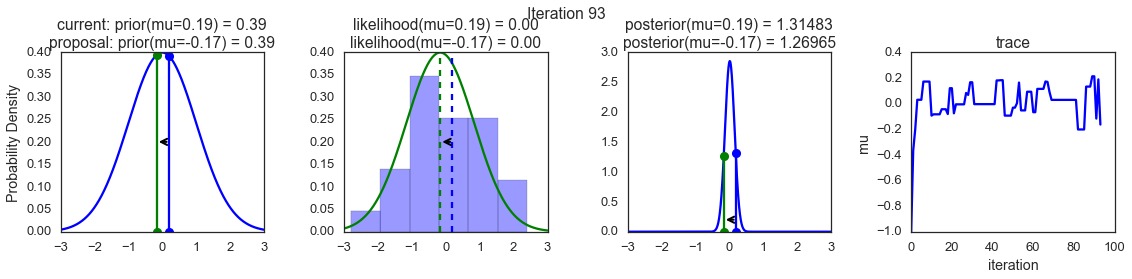

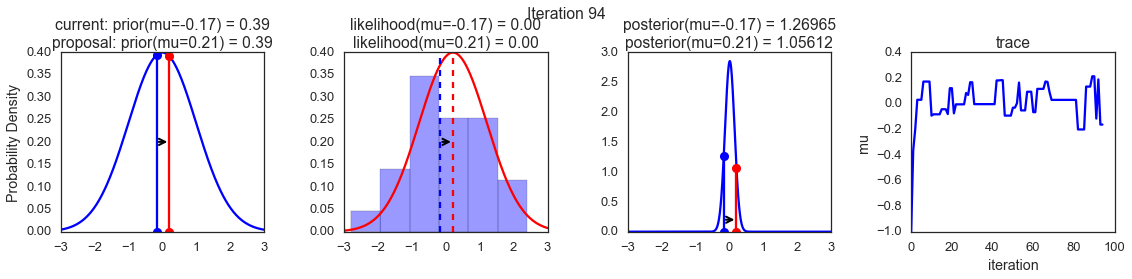

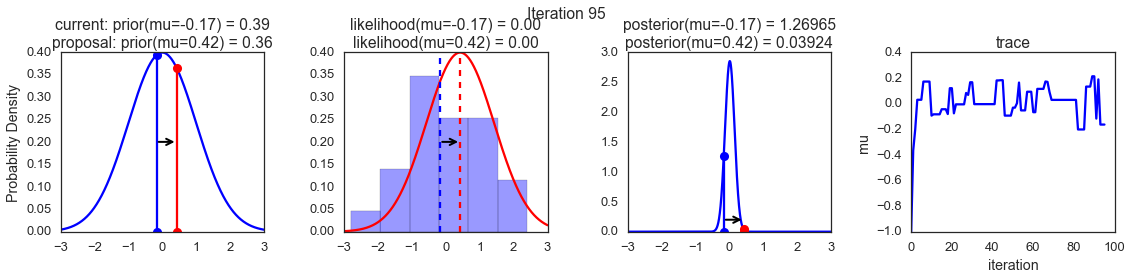

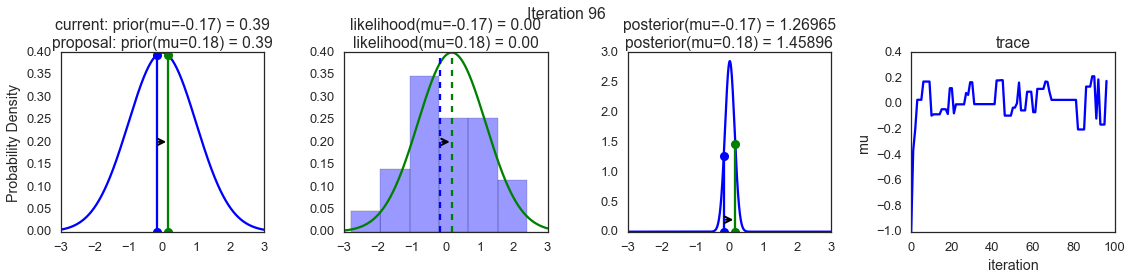

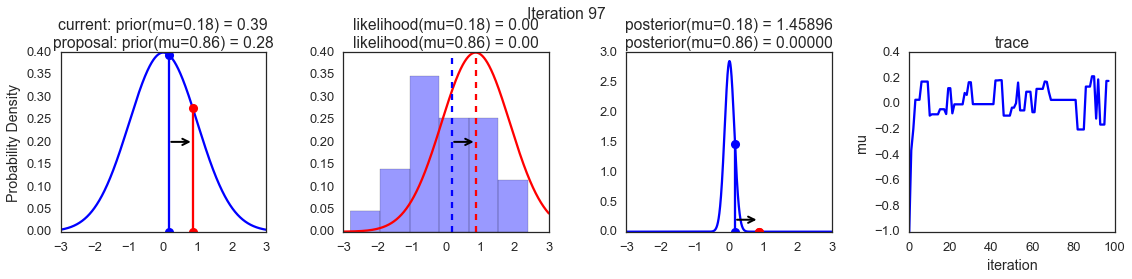

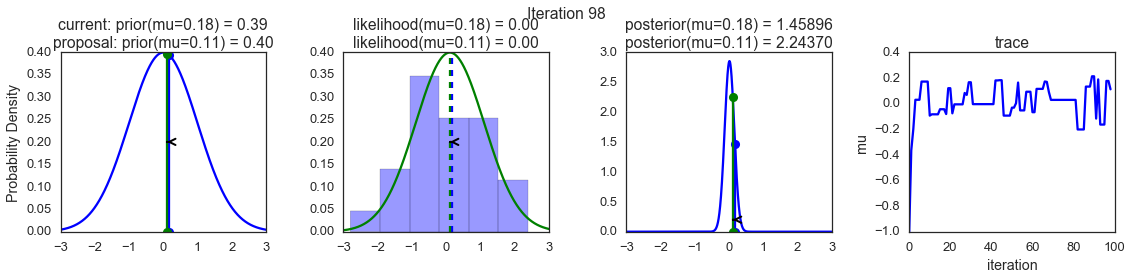

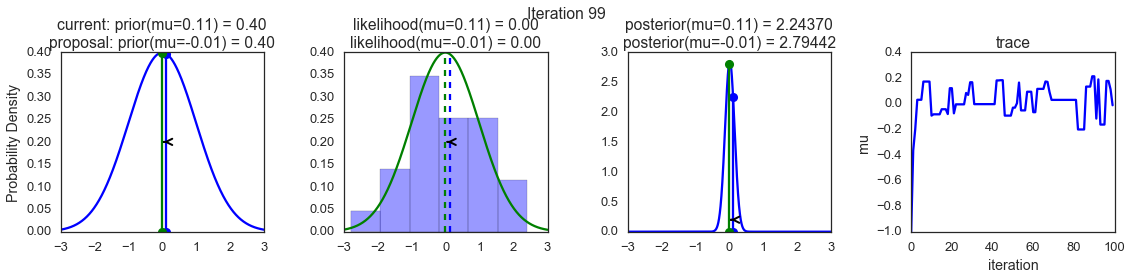

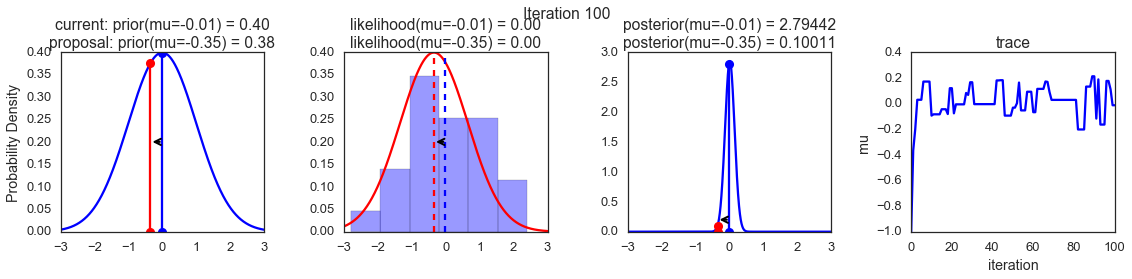

In [143]:
#np.random.seed(123)
A= sampler(data, samples=100, mu_init=-1., plot=True);
plt.show()

In [144]:
A

[-1.0,
 -0.36635067747282357,
 -0.19996818884576503,
 0.028167258755350311,
 0.028167258755350311,
 0.028167258755350311,
 0.17002993664086896,
 0.17002993664086896,
 0.17002993664086896,
 0.17002993664086896,
 -0.095307343245943088,
 -0.085149344128630788,
 -0.085149344128630788,
 -0.085149344128630788,
 -0.085149344128630788,
 -0.045535837083324593,
 -0.045535837083324593,
 -0.045535837083324593,
 -0.083096131070240359,
 0.11844684953944315,
 0.11844684953944315,
 -0.077363055820357629,
 -0.0073740027630758154,
 -0.0073740027630758154,
 -0.0073740027630758154,
 -0.0073740027630758154,
 -0.0073740027630758154,
 0.08122216183641813,
 0.066238158312646997,
 0.16474762458438502,
 0.16474762458438502,
 -0.0058832335189078766,
 -0.0058832335189078766,
 -0.0058832335189078766,
 -0.0058832335189078766,
 -0.0058832335189078766,
 -0.0058832335189078766,
 -0.0058832335189078766,
 -0.0058832335189078766,
 -0.0058832335189078766,
 -0.0058832335189078766,
 -0.0058832335189078766,
 0.17892655963317